In [47]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as spsp
import scipy.sparse.linalg as splinalg
        
############################################################

class DiffIntOperator:
    def __init__(self, n):
        self.N = n
        self.h = 1.0 / (n - 1)
        self.X = np.linspace(0, 1, n)
        
    def Kernel(self, i, j):
        return np.sin(self.X[i] + self.X[j]) / (1.0 + self.X[i] + self.X[j])
        
    # Simple A operator
    def setOperator(self):
        self.A = splinalg.LinearOperator((self.N - 2, self.N - 2), matvec=self.mvA)
    def setFullFormOperator(self):
        self.Afull = self.A.matmat(np.identity(self.N - 2))
        
    # Diagonal operator
    def setDiagonalOperator(self):
        self.AD = splinalg.LinearOperator((self.N - 2, self.N - 2), matvec=self.mvAD)
    def setFullFormDiagonalOperator(self):
        self.ADfull = self.AD.matmat(np.identity(self.N - 2))
    
    # Upper
    def setUpperOperator(self):
        self.AU = splinalg.LinearOperator((self.N - 2, self.N - 2), matvec=self.mvAU)
    def setFullFormUpperOperator(self):
        self.AUfull = self.AU.matmat(np.identity(self.N - 2))
    
    # Lower
    def setLowerOperator(self):
        self.AL = splinalg.LinearOperator((self.N - 2, self.N - 2), matvec=self.mvAL)
    def setFullFormLowerOperator(self):
        self.ALfull = self.AL.matmat(np.identity(self.N - 2))
        
    # Mix
    def setMixOperator(self):
        self.AMix = splinalg.LinearOperator((self.N - 2, self.N - 2), matvec=self.mvMix)
    def setFullFormMixOperator(self):
        self.AMixfull = self.AMix.matmat(np.identity(self.N - 2))
        
    # Laplace
    def setLaplaceOperator(self):
        self.Laplace = splinalg.LinearOperator((self.N - 2, self.N - 2), matvec=self.mvLaplace)
    def setFullFormLaplaceOperator(self):    
        self.Laplacefull = self.Laplace.matmat(np.identity(self.N - 2))

    ############################################################
    # Splitting: A = L + D + U
    # Full A
    def mvA(self, u):
        k = len(u)
        v = np.zeros(k)
        h2 = self.h**2

        for i in range(0, k):
            res = 0.0
            res += 0.5 * (self.Kernel(i+1, 1) * u[0]) * self.h 
            res += 0.5 * (self.Kernel(i+1, k) * u[k-1]) * self.h
            for j in range(0, k-1):
                res += 0.5 * (self.Kernel(i+1, j+1) * u[j]) * self.h
                res += 0.5 * (self.Kernel(i+1, j+2) * u[j+1]) * self.h

            if i == 0:
                v[i] += -(u[1]) / h2
                v[i] += -( -2*u[0] ) / h2
            elif i == k-1:
                v[i] += -(u[k-2]) / h2
                v[i] += -( -2*u[k-1] ) / h2
            else:
                v[i] += -(u[i+1]) / h2
                v[i] += -( -2*u[i]) / h2
                v[i] += -(u[i-1]) / h2

            v[i] += res

        return v
    
    # Diagonal
    def mvAD(self, u):
        k = len(u)
        v = np.zeros(k)
        h2 = self.h**2

        for i in range(0, k):
            res = 0.0
            if i == 0:
                res += 0.5 * (self.Kernel(i+1, 1) * u[0]) * self.h 
            if i == k-1:
                res += 0.5 * (self.Kernel(i+1, k) * u[k-1]) * self.h
            for j in range(0, k-1):
                if i == j:
                    res += 0.5 * (self.Kernel(i+1, j+1) * u[j]) * self.h
                if i == j+1:
                    res += 0.5 * (self.Kernel(i+1, j+2) * u[j+1]) * self.h

            if i == 0:
                v[i] += -( -2*u[0] ) / h2
            elif i == k-1:
                v[i] += -( -2*u[k-1] ) / h2
            else:
                v[i] += -( -2*u[i]) / h2


            v[i] += res

        return v

    # Lower
    def mvAL(self, u):
        k = len(u)
        v = np.zeros(k)
        h2 = self.h**2

        for i in range(0, k):
            res = 0.0
            if i > 0:
                res += 0.5 * (self.Kernel(i+1, 1) * u[0]) * self.h

            for j in range(0, k-1):
                if i > j:
                    res += 0.5 * (self.Kernel(i+1, j+1) * u[j]) * self.h
                if i > j+1:
                    res += 0.5 * (self.Kernel(i+1, j+2) * u[j+1]) * self.h

            if i == 0:
                pass
            elif i == k-1:
                v[i] += -(u[k-2]) / h2
            else:
                v[i] += -(u[i-1]) / h2

            v[i] += res

        return v

    # Upper
    def mvAU(self, u):
        k = len(u)
        v = np.zeros(k)
        h2 = self.h**2

        for i in range(0, k):
            res = 0.0
            if i < k-1:
                res += 0.5 * (self.Kernel(i+1, k) * u[k-1]) * self.h

            for j in range(0, k-1):
                if i < j:
                    res += 0.5 * (self.Kernel(i+1, j+1) * u[j]) * self.h
                if i < j+1:
                    res += 0.5 * (self.Kernel(i+1, j+2) * u[j+1]) * self.h

            if i == 0:
                v[i] += -(u[1]) / h2
            elif i == k-1:
                pass
            else:
                v[i] += -(u[i+1]) / h2

            v[i] += res

        return v

    # Mix, for testing
    def mvMix(self, u):
        return self.mvL(u) + self.mvD(u) + self.mvU(u)
    
    def mvLaplace(self, u):
        k = len(u)
        v = np.zeros(k)

        for i in range(0, k):
            if i == 0:
                v[i] = (u[1] - 2*u[0]) / self.h**2
            elif i == k-1:
                v[i] = (u[k-2] - 2*u[k-1]) / self.h**2
            else:
                v[i] = (u[i+1] - 2*u[i] + u[i-1]) / self.h**2

        return v
    
############################################################

def RHS(x, i):
    return np.exp(10.0 * x[i]) * np.sin(10.0 * x[i])

############################################################
# Report callback
class ReportCallback:
    def __init__(self, mat, rhs):
        self.A = mat
        self.b = rhs
        self.iters, self.resnorm, self.report_list = 0, 0, []
        
    def report(self, xk):
        self.iters += 1
        self.resnorm = np.linalg.norm(self.A*xk - self.b)
        #print("Iters = %d ; resnorm = %f" % (iters, resnorm))
        self.report_list.append((self.iters, self.resnorm))

In [48]:
N = 100
DIO = DiffIntOperator(N)
b = [RHS(DIO.X, i) for i in range(1, N-1)]
print("Dimension is ", N-2)

print("Full A:")
DIO.setOperator()
DIO.setFullFormOperator()
print(DIO.Afull)

print("Lower:")
DIO.setLowerOperator()
DIO.setFullFormLowerOperator()
print(DIO.ALfull)

print("Diagonal:")
DIO.setDiagonalOperator()
DIO.setFullFormDiagonalOperator()
print(DIO.ADfull)

print("Upper:")
DIO.setUpperOperator()
DIO.setFullFormUpperOperator()
print(DIO.AUfull)

print("Diff:")
print(DIO.ADfull + DIO.ALfull + DIO.AUfull - DIO.Afull)

print(" ")
print(" ")
print(" ")
print("Cond number of A is ", np.linalg.cond(DIO.Afull))

Dimension is  98
Full A:
[[ 1.96020002e+04 -9.80099970e+03  3.92165516e-04 ...  4.23665726e-03
   4.24350534e-03  4.24985346e-03]
 [-9.80099970e+03  1.96020004e+04 -9.80099951e+03 ...  4.24350534e-03
   4.24985346e-03  4.25570635e-03]
 [ 3.92165516e-04 -9.80099951e+03  1.96020006e+04 ...  4.24985346e-03
   4.25570635e-03  4.26106868e-03]
 ...
 [ 4.23665726e-03  4.24350534e-03  4.24985346e-03 ...  1.96020032e+04
  -9.80099682e+03  3.15824150e-03]
 [ 4.24350534e-03  4.24985346e-03  4.25570635e-03 ... -9.80099682e+03
   1.96020032e+04 -9.80099687e+03]
 [ 4.24985346e-03  4.25570635e-03  4.26106868e-03 ...  3.15824150e-03
  -9.80099687e+03  1.96020031e+04]]
Lower:
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-9.80099970e+03  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.92165516e-04 -9.80099951e+03  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 4.2366572

In [49]:
# Jacobi (or diagonal) preconditioner

Jacobi = lambda x: splinalg.spsolve(DIO.ADfull, x)
M_Jacobi = splinalg.LinearOperator((N-2, N-2), matvec=Jacobi)

RC = ReportCallback(DIO.A, b)
x = splinalg.cg(DIO.Afull, b, callback=RC.report)
print("Without precond: ", RC.report_list[-1])
report_list_default = RC.report_list

RC = ReportCallback(DIO.A, b)
x = splinalg.cg(DIO.Afull, b, M=M_Jacobi, callback=RC.report)
print("With precond: ", RC.report_list[-1])
report_list_Jacobi = RC.report_list

Without precond:  (98, 3.810146912920407e-09)
With precond:  (98, 3.4537952501880677e-09)


In [50]:
# Symmetric Gauss-Seidel (SGS)
SGS_matrix = np.matmul(np.matmul(DIO.ADfull + DIO.ALfull, np.linalg.inv(DIO.ADfull)), DIO.ADfull + DIO.AUfull)
SGS = lambda x: splinalg.spsolve(SGS_matrix, x)
M_SGS = splinalg.LinearOperator((N-2, N-2), matvec=SGS)

RC = ReportCallback(DIO.A, b)
x = splinalg.cg(DIO.Afull, b, callback=RC.report)
print("Without precond: ", RC.report_list[-1])

RC = ReportCallback(DIO.A, b)
x = splinalg.cg(DIO.Afull, b, M=M_SGS, callback=RC.report)
print("With precond: ", RC.report_list[-1])
report_list_SGS = RC.report_list

Without precond:  (98, 3.810146912920407e-09)
With precond:  (40, 0.17255214767066657)


In [51]:
# Laplace precond

DIO.setLaplaceOperator()
DIO.setFullFormLaplaceOperator()

LaplacePrecond = lambda x: splinalg.spsolve(DIO.Laplacefull, x)
M_LaplacePrecond = splinalg.LinearOperator((N-2, N-2), matvec=LaplacePrecond)

RC = ReportCallback(DIO.A, b)
A = DIO.Afull
x = splinalg.cg(DIO.Afull, b, callback=RC.report)
print("Without precond: ", RC.report_list[-1])

RC = ReportCallback(DIO.A, b)
A = DIO.Afull
x = splinalg.cg(DIO.Afull, b, M=M_LaplacePrecond, callback=RC.report)
print("With precond: ", RC.report_list[-1])
report_list_Laplace = RC.report_list

Without precond:  (98, 3.810146912920407e-09)
With precond:  (3, 1.6791724640226613e-06)


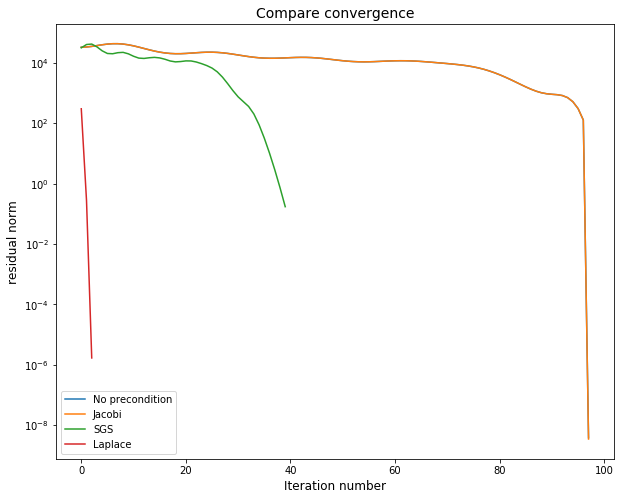

In [52]:
plt.figure(figsize=(10, 8))
plt.plot(list(map(lambda x: x[1], report_list_default)), label="No precondition")
plt.plot(list(map(lambda x: x[1], report_list_Jacobi)), label="Jacobi")
plt.plot(list(map(lambda x: x[1], report_list_SGS)), label="SGS")
plt.plot(list(map(lambda x: x[1], report_list_Laplace)), label="Laplace")
plt.title("Compare convergence", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.yscale('log')
plt.ylabel("residual norm", fontsize=12)
plt.legend()

In [68]:
# Check convergence

def solution(x):
    return np.exp(x) * np.sin(x)

def getError(N):
    DIO = DiffIntOperator(N)
    sol = [solution(DIO.X[i]) for i in range(1, N-1)]
    
    DIO.setOperator()
    DIO.setFullFormOperator()
    
    DIO.setLaplaceOperator()
    DIO.setFullFormLaplaceOperator()
    LaplacePrecond = lambda x: splinalg.spsolve(DIO.Laplacefull, x)
    M_LaplacePrecond = splinalg.LinearOperator((N-2, N-2), matvec=LaplacePrecond)
    
    b = DIO.A*sol
    x = (splinalg.cg(DIO.Afull, b, M=M_LaplacePrecond))[0]
    errL2 = np.linalg.norm(np.array(x) - np.array(sol)) * DIO.h**2
    errC = abs(max(abs(np.array(x))) - max(abs(np.array(sol))))
    return errC, errL2

errC, errL2 = getError(20)
print("N=20. Error(C) is ", errC, " error(L2) is ", errL2)
errC, errL2 = getError(40)
print("N=40. Error(C) is ", errC, " error(L2) is ", errL2)
errC, errL2 = getError(80)
print("N=80. Error(C) is ", errC, " error(L2) is ", errL2)
errC, errL2 = getError(160)
print("N=160. Error(C) is ", errC, " error(L2) is ", errL2)

N=20. Error(C) is  7.088928510867731e-08  error(L2) is  1.4168299279019853e-07
N=40. Error(C) is  4.3356009005179885e-08  error(L2) is  5.676306248968042e-08
N=80. Error(C) is  2.3715132080326384e-08  error(L2) is  2.1245100075130537e-08
N=160. Error(C) is  1.2372075364197599e-08  error(L2) is  7.718581652604617e-09
